In [1]:
import pandas as pd
from catboost import CatBoostClassifier
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from utils.general_utils import load_data_old, get_cat_feature_names
from utils.model_extensions_utils import FocalLossObjective
from utils.plot_utils import Evaluation
# from utils.fe_utils import get_growth_features
from explainerdashboard import ClassifierExplainer, ExplainerDashboard, InlineExplainer
import matplotlib.pyplot as plt
import shap
from utils.fe_utils import get_growth_features



The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


In [2]:
def process_df(X_temp):
    # - remove zero variance features
    # cols_to_drop = [col for col in X_temp.select_dtypes(include=np.number).columns if np.std(X_temp[col]) == 0]
    # X_temp = X_temp.drop(cols_to_drop, axis=1)
    tech_cols = ['maven', 'generic', 'docker', 'npm', 'pypi', 'gradle', 'nuget']
    usage_cols = tech_cols + ['artifacts_count', 'artifacts_size', 'binaries_count', 'binaries_size', 'items_count',
                              'number_of_permissions', 'internal_groups', 'number_of_users', 'n_env', 'n_tech',
                              'n_repos']
    X_temp['n_tech'] = (X_temp[tech_cols] != 0).astype(int).sum(axis=1)
    X_temp['n_tech.1'] = (X_temp[[col + '.1' for col in tech_cols]] != 0).astype(int).sum(axis=1)
    X_temp['n_tech.2'] = (X_temp[[col + '.2' for col in tech_cols]] != 0).astype(int).sum(axis=1)
    X_temp['n_tech.3'] = (X_temp[[col + '.3' for col in tech_cols]] != 0).astype(int).sum(axis=1)
    X_temp['n_tech.4'] = (X_temp[[col + '.4' for col in tech_cols]] != 0).astype(int).sum(axis=1)
    X_temp['n_repos'] = (X_temp[tech_cols]).sum(axis=1)
    X_temp['n_repos.1'] = (X_temp[[col + '.1' for col in tech_cols]]).sum(axis=1)
    X_temp['n_repos.2'] = (X_temp[[col + '.2' for col in tech_cols]]).sum(axis=1)
    X_temp['n_repos.3'] = (X_temp[[col + '.3' for col in tech_cols]]).sum(axis=1)
    X_temp['n_repos.4'] = (X_temp[[col + '.4' for col in tech_cols]]).sum(axis=1)
    # X_temp['leading_tech'] = list(X_temp[tech_cols].idxmax(axis=1))
    # X_temp.loc[X_temp['leading_tech'].isin(['npm', 'gradle', 'pypi']), 'leading_tech'] = 'else'

    # - get trends features
    for col in usage_cols:
        growth_feature_monthly, growth_feature_quarter, df_fg = get_growth_features(col, X_temp.copy())
        X_temp[col + '_monthly_growth'] = growth_feature_monthly
        X_temp[col + '_quarter_growth'] = growth_feature_quarter


    # - transform to category
    cat_features = get_cat_feature_names(X_temp)
    for col in cat_features:
        X_temp[col] = X_temp[col].astype('category')

    # - drop usage features from the periods before the relevant-date
    cols_to_drop = [col for col in X_temp.columns if '.1' in col or '.2' in col or '.3' in col or '.4' in col]
    X_temp = X_temp.drop(cols_to_drop, axis=1)
    X_temp['artifacts/binaries_size'] = np.where(X_temp['binaries_size'] == 0, 0, X_temp['artifacts_size'] / X_temp['binaries_size'])
    X_temp['artifacts/binaries_count'] = np.where(X_temp['binaries_count'] == 0, 0, X_temp['artifacts_count'] / X_temp['binaries_count'])
    X_temp = X_temp.drop(['total_employees_with_details', 'days_from_contact_added', 'territory', 'industry_group',
                          'total_employees_range'], axis=1)
    return X_temp

In [3]:
consolidate_opps = True
df = load_data_old('fit.sql')

In [4]:
df

,account_id,relevant_date,class,territory,account_id.1,relevant_date.1,period_range,artifacts_count,artifacts_size,binaries_count,...,n_ent_mentioned_sessions,n_competitor_mentioned_sessions,n_xray_mentioned_sessions,n_replys,n_sent,n_calls,n_task_xray,replys_to_sent,days_since_reply,days_since_sent
0,0011r00001iACCU,2018-08-25 00:00:00,0,EMEA,0011r00001iACCU,2018-08-25 00:00:00,3 Months,1289272,14066,638194,...,0,0,0,0,0,0,0,-1.000000,1000,1000
1,0011r00001iACCU,2019-08-09 00:00:00,0,EMEA,0011r00001iACCU,2019-08-09 00:00:00,3 Months,1844459,27343,875317,...,0,0,0,0,1,0,0,0.000000,259,85
2,0011r00001iACCU,2020-08-27 00:00:00,0,EMEA,0011r00001iACCU,2020-08-27 00:00:00,3 Months,515803,35022,397341,...,0,0,1,1,6,0,0,0.166667,9,9
3,0011r00001iACCU,2021-07-30 00:00:00,0,EMEA,0011r00001iACCU,2021-07-30 00:00:00,3 Months,642349,26485,459664,...,0,0,0,0,0,0,0,-1.000000,158,161
4,0011r00001iACGM,2019-08-30 00:00:00,0,EMEA,0011r00001iACGM,2019-08-30 00:00:00,3 Months,56486,234,48490,...,0,0,0,0,2,0,0,0.000000,1000,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5838,001w000001kgU5v,2018-08-30 00:00:00,0,Americas,001w000001kgU5v,2018-08-30 00:00:00,3 Months,132,0,128,...,0,0,0,0,0,0,0,-1.000000,1000,1000
5839,001w000001kgfaR,2018-10-16 00:00:00,0,EMEA,001w000001kgfaR,2018-10-16 00:00:00,3 Months,24491,623,14349,...,0,0,0,0,0,0,0,-1.000000,1000,1000
5840,001w000001kgfaR,2019-10-15 00:00:00,0,EMEA,001w000001kgfaR,2019-10-15 00:00:00,3 Months,36144,872,22216,...,0,0,0,0,0,0,0,-1.000000,1000,152
5841,001w000001kgfaR,2020-09-19 00:00:00,0,EMEA,001w000001kgfaR,2020-09-19 00:00:00,3 Months,61167,1073,37468,...,0,0,0,0,0,0,0,-1.000000,1000,180


In [5]:
if consolidate_opps:
    has_won = df.groupby('account_id', as_index=False).sum('class').loc[:, ['account_id', 'class']]
    has_won['has_won'] = has_won['class'].apply(lambda x: True if x > 0 else False)
    has_won.drop('class', axis=1, inplace=True)
    new_df = df.merge(has_won, on='account_id')
    df_did_win, df_did_not_win = new_df[new_df['has_won']], new_df[~new_df['has_won']]
    df_did_win = df_did_win[df_did_win['class'] == 1].groupby('account_id', as_index=False).min('relevant_date')
    df_did_not_win = df_did_not_win.groupby('account_id').sample(n=1, random_state=2)
    df = pd.concat([df_did_win, df_did_not_win])
    df = df.sample(frac=1, random_state=2).reset_index(drop=True)

In [6]:
cols_to_drop = [col for col in df.columns if 'period_range' in col or 'relevant_date' in col or 'account_id' in col
                or 'class' in col or 'has_won' in col]
X, y = df.drop(cols_to_drop, axis=1).fillna(-1), df['class']
X = process_df(X)

In [7]:
print(len(X.columns))
list(X.columns)

103


['artifacts_count',
 'artifacts_size',
 'binaries_count',
 'binaries_size',
 'items_count',
 'number_of_permissions',
 'internal_groups',
 'number_of_users',
 'n_env',
 'maven',
 'generic',
 'docker',
 'npm',
 'pypi',
 'gradle',
 'nuget',
 'n_contacts',
 'n_active_contracts',
 'is_cotermed',
 'count_ent',
 'count_prox',
 'count_pro',
 'n_security_contacts',
 'n_sessions_last_year',
 'n_cases_last_year',
 'n_xray_sessions_last_year',
 'n_cases_last_3_months',
 'n_poor_cases',
 'engineers',
 'devops_engineers',
 'developers',
 'company_age',
 'n_training',
 'qoe_score',
 'days_from_artifacts_count_change',
 'days_from_artifacts_size_change',
 'days_from_binaries_count_change',
 'days_from_binaries_size_change',
 'days_from_items_count_change',
 'days_from_permissions_change',
 'days_from_internal_groups_change',
 'days_from_users_change',
 'n_jira_cases',
 'unresolved_jira_cases',
 'avg_resolution_days',
 'pricing_views',
 'artifactory_views',
 'xray_views',
 'support_views_views',
 'kno

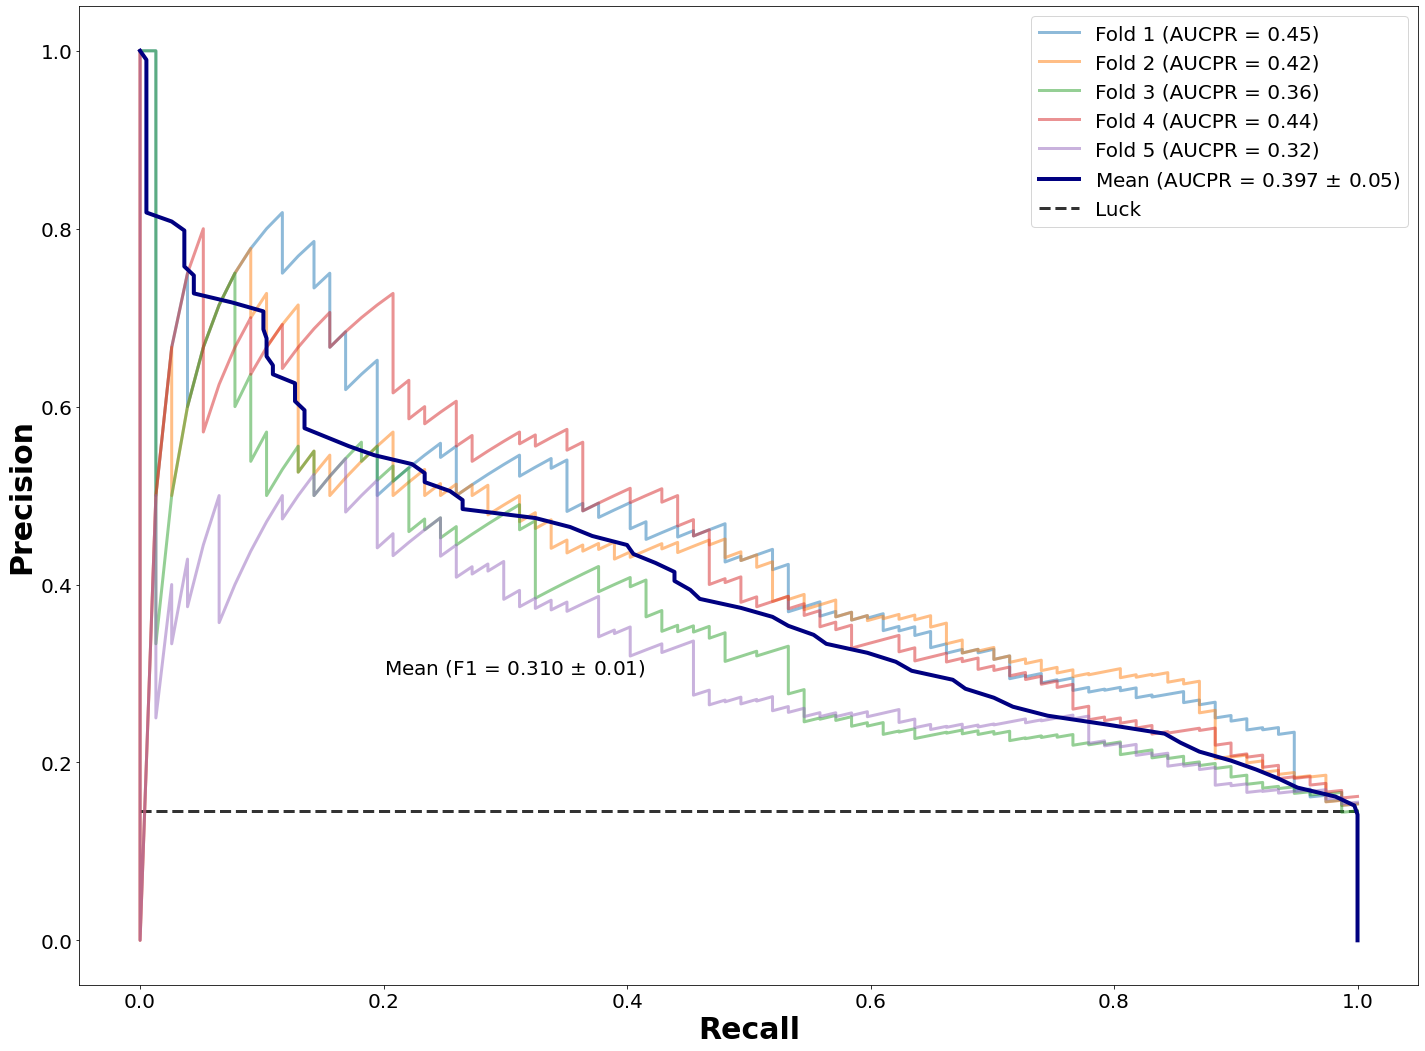

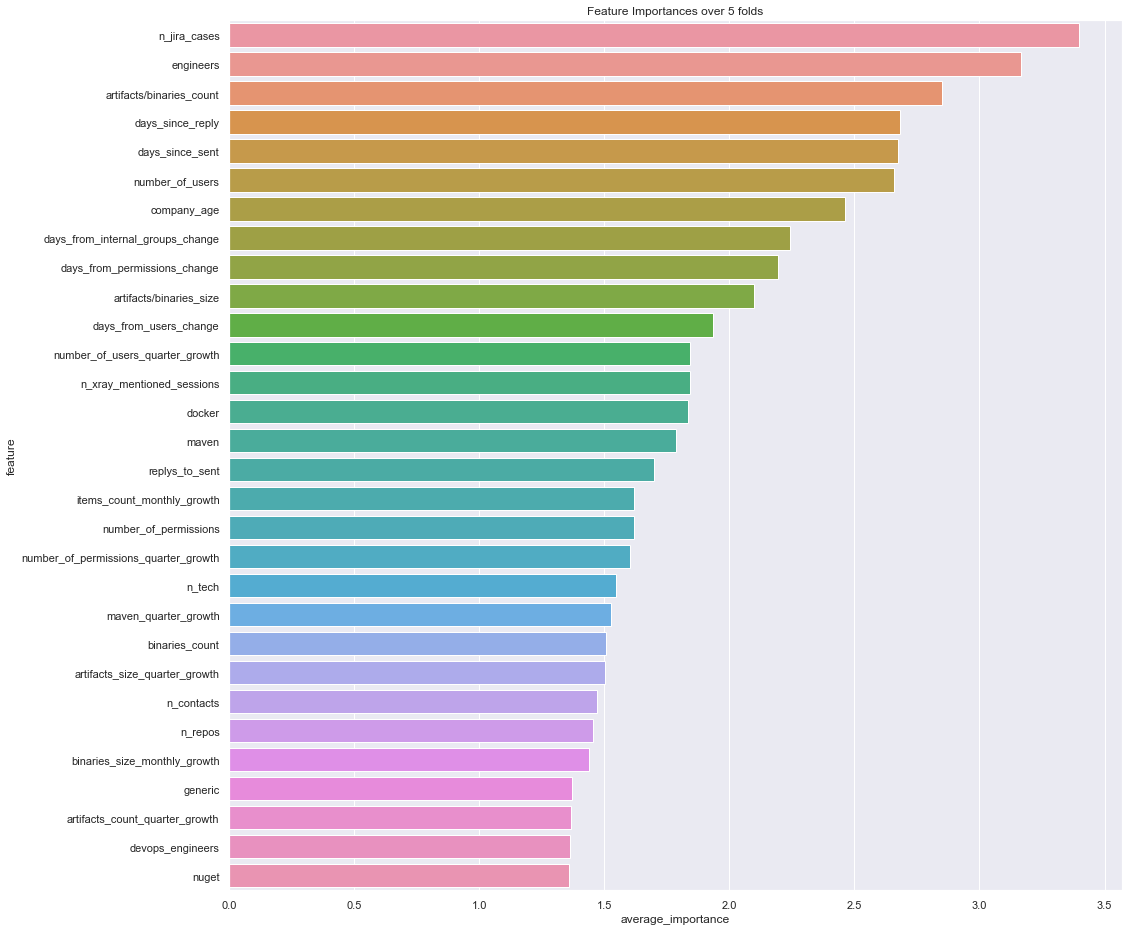

In [8]:
eval = Evaluation()
cbc = CatBoostClassifier(cat_features=get_cat_feature_names(X), auto_class_weights='Balanced', verbose=0,
                         random_state=5, loss_function=FocalLossObjective(), eval_metric="Logloss", bootstrap_type='Bayesian')
lgb = LGBMClassifier(class_weight='balanced', random_state=5)
clfs = [('catboost', cbc), ('lightgbm', lgb)]
stacking = StackingClassifier(estimators=clfs, final_estimator=LogisticRegression(class_weight='balanced'))
feature_importance = eval.plot_cv_precision_recall(clf=cbc, n_folds=5, n_repeats=1, X=X, y=y, stacking=False,
                                              random_state=2, threshold=0.25)
eval.plot_feature_importance(feature_importance.copy(), n_features_to_show=30)

In [9]:
df_for_predict = load_data_old('predict.sql')
cols_to_drop = [col for col in df_for_predict.columns if 'period_range' in col or 'relevant_date' in col or 'account_id' in col
                or 'class' in col or 'has_won' in col]
df_for_predict_clean = df_for_predict.drop(cols_to_drop, axis=1)
df_for_predict_clean = process_df(df_for_predict_clean)
df_for_predict_clean['class_pred_proba'] = cbc.predict_proba(df_for_predict_clean)[:,1]

In [10]:
df_for_predict_clean

,artifacts_count,artifacts_size,binaries_count,binaries_size,items_count,number_of_permissions,internal_groups,number_of_users,n_env,maven,...,number_of_users_quarter_growth,n_env_monthly_growth,n_env_quarter_growth,n_tech_monthly_growth,n_tech_quarter_growth,n_repos_monthly_growth,n_repos_quarter_growth,artifacts/binaries_size,artifacts/binaries_count,class_pred_proba
0,580676,28815,445652,28398,1550056,12,7.0,117,1,2,...,0.008696,0.0,0.00,0.00,0.00,0.000000,-0.237500,1.014684,1.302981,0.351635
1,181381,914,147871,621,260711,11,3.0,43,1,9,...,0.093567,0.0,0.00,0.00,0.00,0.000000,0.088235,1.471820,1.226616,0.285058
2,97439,81,60766,78,133725,3,2.0,112,1,22,...,0.027959,0.0,0.00,0.00,0.00,0.000000,0.000000,1.038462,1.603512,0.222990
3,11052,19,11629,16,16503,3,1.0,7,1,0,...,0.000000,0.0,0.00,0.00,0.00,0.000000,0.000000,1.187500,0.950383,0.164434
4,1416679,20490,763799,8523,1593753,25,10.0,211,5,31,...,0.053881,0.0,0.00,0.00,0.00,0.000000,0.036741,2.404083,1.854780,0.577336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,376233,1547,359650,1513,574413,10,8.0,313,1,28,...,0.057688,0.0,-0.25,0.00,0.00,0.250000,0.220588,1.022472,1.046109,0.401794
2050,11008,3,10977,3,24354,4,3.0,8,1,2,...,0.000000,0.0,0.00,0.00,0.00,-0.250000,0.250000,1.000000,1.002824,0.224106
2051,109502,772,74910,419,154452,105,103.0,680,1,10,...,0.174354,0.0,0.00,0.25,0.25,0.090909,0.087121,1.842482,1.461781,0.270212
2052,79787,82,76603,80,137812,5,2.0,72,1,54,...,0.029101,0.0,0.00,0.00,0.25,0.000000,0.075000,1.025000,1.041565,0.361386


In [11]:
df_for_predict_clean['class_pred'] = df_for_predict_clean['class_pred_proba'].apply(lambda x: 1 if x >= 0.5 else 0)

In [12]:
np.sum(df_for_predict_clean['class_pred'])

116

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

In [14]:
cbc.fit(X_train, y_train)

In [15]:
explainer = ClassifierExplainer(cbc, X_test, y_test)

Note: model_output=='probability'. For CatBoostClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...


In [16]:
# ExplainerDashboard(explainer).run()

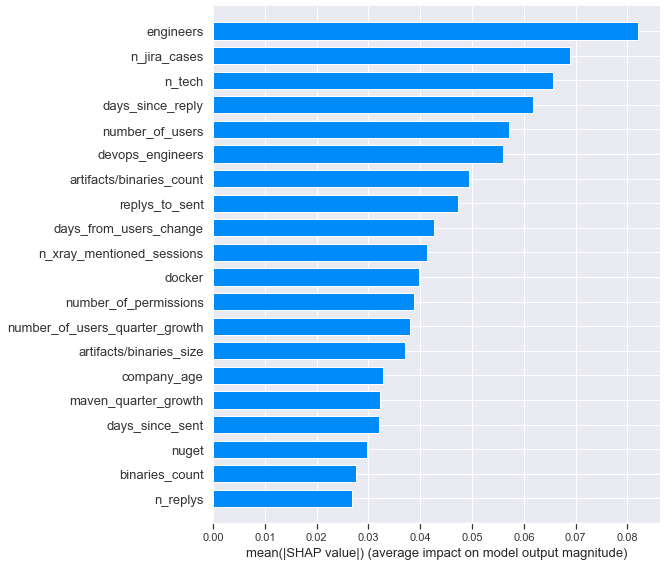

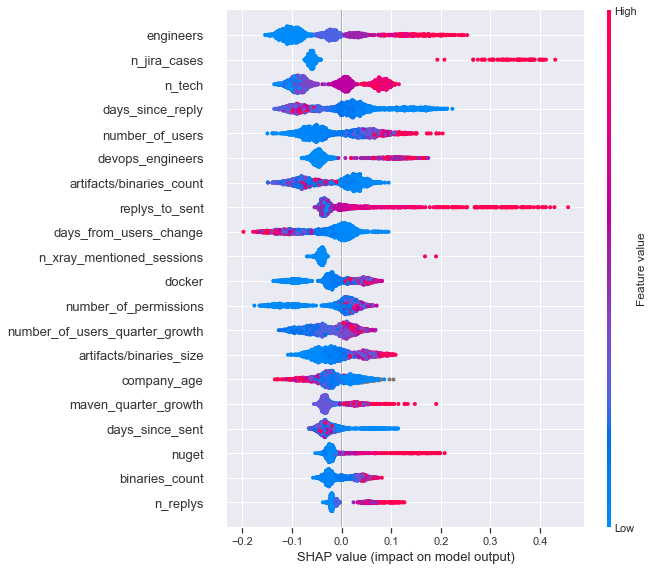

In [17]:
shap_values = shap.TreeExplainer(cbc).shap_values(df_for_predict_clean)
shap.summary_plot(shap_values, df_for_predict_clean, plot_type="bar")
f = plt.figure()
shap.summary_plot(shap_values, df_for_predict_clean)
# f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

In [18]:
df_for_predict_clean['account_id'] = df_for_predict['account_id']
df_for_predict_clean.loc[df_for_predict_clean['class_pred'] == 1,'account_id'].head(50)

4       0011r00001iAr7V
44      0011r00001l0WA2
51      0011r00001lphqp
58      0011r00001lpyxA
81      0011r00001lsetu
95      0011r00001miaQ5
116     0011r00001mxbY1
157     0011r00001pShrJ
179     0011r00001qixN0
192     0011r00001qkWH4
208     0011r00001vM5Co
209     0011r00001vMTkk
210     0011r00001vMarX
231     0011r00001wvaln
258     0011r00001ycjpE
261     0011r00001ycwVN
278     0011r00001yfroD
288     0011r00001zfIfr
292     0011r00001zfrjX
305     0011r000020oRB3
315     0011r000021s424
391     0011r000029Vvz6
449     0011r00002Ejmve
476     0011r00002HCYj6
481     0011r00002HCmFY
502     0011r00002IAR5l
510     0011r00002InY0D
526     0011r00002JEGZJ
547     0011r00002JtmTH
626     0011r00002NF2Pn
630     0011r00002O0cAQ
690     0011r00002Q8eXc
723     0011r00002Rh1Bg
732     0011r00002RiDIi
792     0011r00002T7HOr
824     0011r00002UPvgb
825     0011r00002UQ6vz
868     0011r00002WN4Tk
877     0011r00002X1uQq
897     0011r00002XhA0C
949     0012000000nM0IV
950     00120000

In [19]:
print("ih")

ih
